In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glaucoma-detection/glaucoma.csv
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/537.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/521.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/539.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/501.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/544.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/489.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/576.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Negative/503.jpg
/kaggle/input/glaucoma-detection/Fundus_Train_Val_

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


# Prepare Glaucoma Dataset

In [3]:
class FullGlaucomaDataset(Dataset):
    def __init__(self, fundus_dir, origa_mat, origa_img_dir, acrima_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # Fundus dataset
        for label_dir in ["Glaucoma_Negative", "Glaucoma_Positive"]:
            full_dir = os.path.join(fundus_dir, "Train", label_dir)
            label = 0 if "Negative" in label_dir else 1
            for f in glob.glob(full_dir + "/*.jpg"):
                self.samples.append((f,label))
        
        # ORIGA dataset
        import scipy.io
        origa_data = scipy.io.loadmat(origa_mat)['Origa']
        for i in range(len(origa_data[0])):
            fname = origa_data[0][i]['Filename'][0]
            label = int(origa_data[0][i]['Glaucoma'][0][0])
            img_path = os.path.join(origa_img_dir, fname)
            if os.path.exists(img_path):
                self.samples.append((img_path, label))
        
        # ACRIMA dataset
        for f in glob.glob(acrima_dir + "/*.jpg"):
            fname = os.path.basename(f)
            label = 1 if "_g_" in fname else 0
            self.samples.append((f,label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")  # 3 channels
        if self.transform:
            img = self.transform(img)
        return img, label


# Train/Validatin Split

In [4]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# 1️⃣ Transforms
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))  # Cutout augmentation
])

# Validation: no augmentation
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# 2️⃣ Paths
fundus_dir = "/kaggle/input/glaucoma-detection/Fundus_Train_Val_Data/Fundus_Scanes_Sorted"
origa_mat = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/OrigaList.mat"
origa_img_dir = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
acrima_dir = "/kaggle/input/glaucoma-detection/ACRIMA/Images"

# 3️⃣ Instantiate full dataset
full_dataset = FullGlaucomaDataset(
    fundus_dir=fundus_dir,
    origa_mat=origa_mat,
    origa_img_dir=origa_img_dir,
    acrima_dir=acrima_dir,
    transform=transform_train
)

# 4️⃣ Train/validation split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# 5️⃣ DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32,  # Adjust based on GPU memory
    shuffle=True, 
    num_workers=4,  # Use 4 workers for faster data loading
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

print("Total samples:", len(full_dataset))
print("Train:", len(train_dataset), "Validation:", len(val_dataset))


Total samples: 1873
Train: 1498 Validation: 375


# Visualize Some Images

Training set samples:


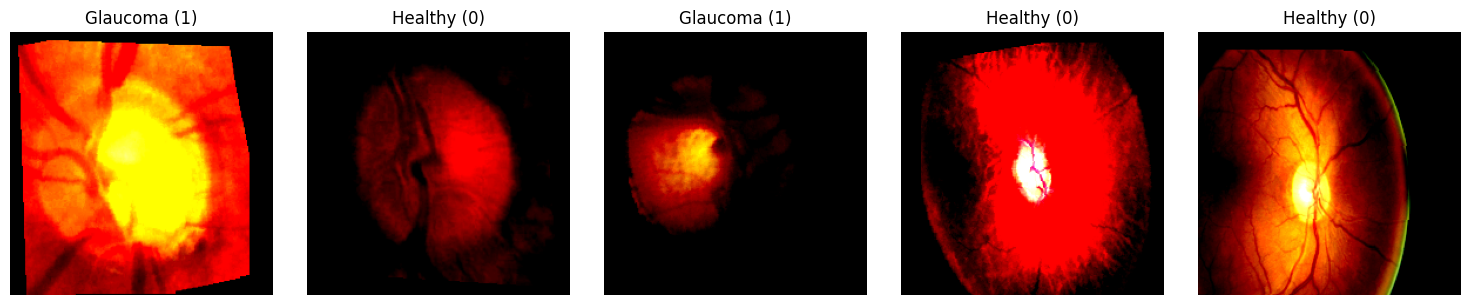

Validation set samples:


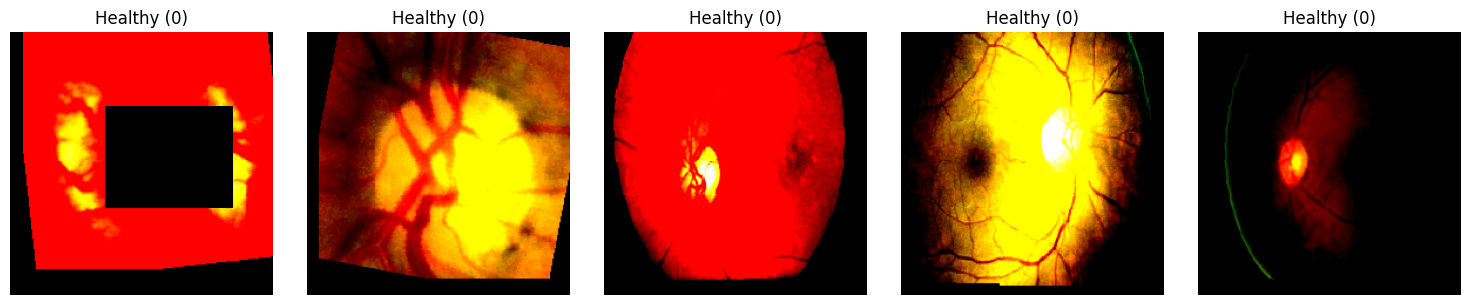

In [5]:
import matplotlib.pyplot as plt
import torch

# Label mapping
classes = ['Healthy (0)', 'Glaucoma (1)']

def show_samples(loader, num_samples=5):
    """
    Display sample RGB images from a DataLoader in a grid.
    """
    images, labels = next(iter(loader))  # get one batch
    num_samples = min(num_samples, len(images))
    
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).cpu()  # (C, H, W) -> (H, W, C)
        label = labels[i].item()
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show samples from training and validation sets
print("Training set samples:")
show_samples(train_loader, num_samples=5)

print("Validation set samples:")
show_samples(val_loader, num_samples=5)


# Residual Neural Network Model

In [6]:
"""
Advanced ResNet Model for Glaucoma Detection
Features:
- ResNet-50 backbone with modern improvements
- SE (Squeeze-and-Excitation) attention
- CBAM (Convolutional Block Attention Module)
- Enhanced Spatial Pyramid Pooling with dimensional reduction
- Multiple loss functions
- Best practices for medical imaging
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

# ==================== ATTENTION MODULES ====================
class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block - Channel Attention"""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
   
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excitation(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ChannelAttention(nn.Module):
    """Channel Attention Module from CBAM"""
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
       
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
   
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = self.sigmoid(avg_out + max_out)
        return x * out

class SpatialAttention(nn.Module):
    """Spatial Attention Module from CBAM"""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
   
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.sigmoid(self.conv(out))
        return x * out

class CBAM(nn.Module):
    """Convolutional Block Attention Module (Channel + Spatial)"""
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = ChannelAttention(channels, reduction)
        self.spatial_att = SpatialAttention(kernel_size)
   
    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

# ==================== RESIDUAL BLOCKS ====================
class BasicBlock(nn.Module):
    """ResNet Basic Block with CBAM attention"""
    expansion = 1
   
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, use_cbam=True):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.cbam = CBAM(out_channels) if use_cbam else None
        self.dropout = nn.Dropout2d(0.1)
   
    def forward(self, x):
        identity = x
       
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
       
        out = self.conv2(out)
        out = self.bn2(out)
       
        if self.cbam is not None:
            out = self.cbam(out)
       
        if self.downsample is not None:
            identity = self.downsample(x)
       
        out += identity
        out = self.relu(out)
       
        return out

class Bottleneck(nn.Module):
    """ResNet Bottleneck Block with CBAM attention"""
    expansion = 4
   
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, use_cbam=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.cbam = CBAM(out_channels * self.expansion) if use_cbam else None
        self.dropout = nn.Dropout2d(0.1)
   
    def forward(self, x):
        identity = x
       
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
       
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
       
        out = self.conv3(out)
        out = self.bn3(out)
       
        if self.cbam is not None:
            out = self.cbam(out)
       
        if self.downsample is not None:
            identity = self.downsample(x)
       
        out += identity
        out = self.relu(out)
       
        return out

# ==================== ENHANCED SPATIAL PYRAMID POOLING ====================
class SpatialPyramidPooling(nn.Module):
    """Enhanced SPP layer with per-branch dimensional reduction for efficiency"""
    def __init__(self, channels, pool_sizes=[1, 2, 4], reduced_dim=512):
        super(SpatialPyramidPooling, self).__init__()
        self.channels = channels
        self.pool_sizes = pool_sizes
        self.pools = nn.ModuleList([nn.AdaptiveAvgPool2d(s) for s in pool_sizes])
        self.reduced_dim = reduced_dim
        flat_sizes = [channels * s * s for s in pool_sizes]
        self.fcs = nn.ModuleList([nn.Linear(fs, reduced_dim) for fs in flat_sizes])
       
    def forward(self, x):
        # Ensure input channels match
        assert x.size(1) == self.channels, f"Expected {self.channels} channels, got {x.size(1)}"
        features = []
        for i, pool in enumerate(self.pools):
            pooled = pool(x)
            flat = pooled.flatten(1)
            proj = self.fcs[i](flat)
            features.append(proj)
        return torch.cat(features, dim=1)

# ==================== ADVANCED RESNET ====================
class AdvancedResNet(nn.Module):
    """
    Advanced ResNet for Glaucoma Detection with:
    - CBAM attention modules
    - Enhanced Spatial Pyramid Pooling with dimensional reduction
    - Dropout regularization
    - Multiple classifier heads
    - Label smoothing ready
    """
    def __init__(self, block, layers, num_classes=2, in_channels=3,
                 use_cbam=True, use_spp=True, dropout_rate=0.5):
        super(AdvancedResNet, self).__init__()
        self.in_channels = 64
        self.use_cbam = use_cbam
        self.use_spp = use_spp
       
        # Initial convolution layers
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
       
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
       
        # Compute final channels after layer4
        final_channels = 512 * block.expansion
       
        # Enhanced Spatial Pyramid Pooling
        if use_spp:
            self.spp = SpatialPyramidPooling(final_channels, pool_sizes=[1, 2, 4], reduced_dim=512)
            spp_output_size = len([1, 2, 4]) * 512  # 3 * reduced_dim
            self.spp_fc = nn.Sequential(
                nn.Linear(spp_output_size, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.BatchNorm1d(2048)
            )
        else:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
       
        # Main classifier
        classifier_input = 2048 if use_spp else final_channels
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
       
        # Auxiliary classifier (for deep supervision)
        aux_channels = 256 * block.expansion
        self.aux_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(aux_channels, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
       
        self._initialize_weights()
   
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
       
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample, self.use_cbam))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, use_cbam=self.use_cbam))
       
        return nn.Sequential(*layers)
   
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
   
    def forward(self, x, return_aux=False):
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
       
        # ResNet blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
       
        # Auxiliary output (from layer3 for deep supervision)
        if return_aux and self.training:
            aux_out = self.aux_classifier(x)
        else:
            aux_out = None
       
        x = self.layer4(x)
       
        # SPP or regular pooling
        if self.use_spp:
            x = self.spp(x)
            x = self.spp_fc(x)
        else:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
       
        # Main classifier
        x = self.classifier(x)
       
        if return_aux and aux_out is not None:
            return x, aux_out
        return x

# ==================== MODEL VARIANTS ====================
def AdvancedResNet18(num_classes=2, in_channels=3, use_cbam=True, use_spp=True, dropout_rate=0.5):
    """ResNet-18 with advanced features"""
    return AdvancedResNet(BasicBlock, [2, 2, 2, 2], num_classes, in_channels,
                         use_cbam, use_spp, dropout_rate)

def AdvancedResNet34(num_classes=2, in_channels=3, use_cbam=True, use_spp=True, dropout_rate=0.5):
    """ResNet-34 with advanced features"""
    return AdvancedResNet(BasicBlock, [3, 4, 6, 3], num_classes, in_channels,
                         use_cbam, use_spp, dropout_rate)

def AdvancedResNet50(num_classes=2, in_channels=3, use_cbam=True, use_spp=True, dropout_rate=0.5):
    """ResNet-50 with advanced features - RECOMMENDED"""
    return AdvancedResNet(Bottleneck, [3, 4, 6, 3], num_classes, in_channels,
                         use_cbam, use_spp, dropout_rate)

def AdvancedResNet101(num_classes=2, in_channels=3, use_cbam=True, use_spp=True, dropout_rate=0.5):
    """ResNet-101 with advanced features - For large datasets"""
    return AdvancedResNet(Bottleneck, [3, 4, 23, 3], num_classes, in_channels,
                         use_cbam, use_spp, dropout_rate)

# ==================== EXAMPLE USAGE ====================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   
    # Create model (ResNet-50 recommended for best accuracy)
    model = AdvancedResNet50(
        num_classes=2,
        in_channels=3,
        use_cbam=True,
        use_spp=True,
        dropout_rate=0.5
    ).to(device)
   
    print("="*70)
    print("Advanced ResNet-50 Model for Glaucoma Detection")
    print("="*70)
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print("="*70)
   
    # Test forward pass
    model.train()
    dummy_input = torch.randn(4, 3, 224, 224).to(device)
   
    # Training mode (with auxiliary output)
    output, aux_output = model(dummy_input, return_aux=True)
    print(f"\nTraining mode:")
    print(f" Main output shape: {output.shape}")
    print(f" Auxiliary output shape: {aux_output.shape}")
   
    # Evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(dummy_input)
    print(f"\nEvaluation mode:")
    print(f" Output shape: {output.shape}")
    print("="*70)

Advanced ResNet-50 Model for Glaucoma Detection
Total parameters: 54,350,948
Trainable parameters: 54,350,948

Training mode:
 Main output shape: torch.Size([4, 2])
 Auxiliary output shape: torch.Size([4, 2])

Evaluation mode:
 Output shape: torch.Size([4, 2])


# Multi GPU Setup

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedResNet50(num_classes=2).to(device)

# Use all available GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


Using 2 GPUs


# Training Loop

🚀 Advanced ResNet-50 Training for Glaucoma Detection
📱 Device: cuda
🎮 GPU: Tesla T4
💾 GPU Memory: 15.83 GB
📊 Total parameters: 54,350,948
🔥 Using 2 GPUs with DataParallel
⚙️  Advanced Training Configuration:
   • Model: ResNet-50 with CBAM + SPP
   • Epochs: 200
   • Initial LR: 0.001
   • Warmup Epochs: 10
   • Batch Size: 32
   • Loss: Focal Loss
   • Auxiliary Loss Weight: 0.3
   • Dropout: 0.5
   • Weight Decay: 0.0001
   • Gradient Clipping: 1.0
   • Early Stopping Patience: 25


Epoch [  1/200] Train: Loss=0.5612, Acc=0.4953 | Val: Loss=0.7330, Acc=0.6240 | Glaucoma Sens: 0.0211 | LR=0.000100 ✅ NEW BEST!


Epoch [  2/200] Train: Loss=0.4922, Acc=0.5134 | Val: Loss=2.7943, Acc=0.5413 | Glaucoma Sens: 0.5000 | LR=0.000200 


Epoch [  3/200] Train: Loss=0.4706, Acc=0.5401 | Val: Loss=8.1521, Acc=0.5387 | Glaucoma Sens: 0.3803 | LR=0.000300 


Epoch [  4/200] Train: Loss=0.4100, Acc=0.5220 | Val: Loss=74.9108, Acc=0.5280 | Glaucoma Sens: 0.5211 | LR=0.000400 


Epoch [  5/200] Train: Loss=0.3762, Acc=0.5441 | Val: Loss=5.7620, Acc=0.6160 | Glaucoma Sens: 0.3310 | LR=0.000500 


Epoch [  6/200] Train: Loss=0.3374, Acc=0.5688 | Val: Loss=1.5289, Acc=0.6133 | Glaucoma Sens: 0.0563 | LR=0.000600 


Epoch [  7/200] Train: Loss=0.3100, Acc=0.5514 | Val: Loss=1.8351, Acc=0.5733 | Glaucoma Sens: 0.5493 | LR=0.000700 


Epoch [  8/200] Train: Loss=0.2777, Acc=0.5648 | Val: Loss=0.7045, Acc=0.6480 | Glaucoma Sens: 0.3099 | LR=0.000800 ✅ NEW BEST!


Epoch [  9/200] Train: Loss=0.2625, Acc=0.5774 | Val: Loss=0.7649, Acc=0.5653 | Glaucoma Sens: 0.0915 | LR=0.000900 


Epoch [ 10/200] Train: Loss=0.2514, Acc=0.5848 | Val: Loss=0.6623, Acc=0.6533 | Glaucoma Sens: 0.6268 | LR=0.001000 ✅ NEW BEST!


Epoch [ 11/200] Train: Loss=0.2489, Acc=0.6095 | Val: Loss=0.6379, Acc=0.6640 | Glaucoma Sens: 0.3521 | LR=0.001000 ✅ NEW BEST!


Epoch [ 12/200] Train: Loss=0.2474, Acc=0.5995 | Val: Loss=0.6667, Acc=0.6480 | Glaucoma Sens: 0.5915 | LR=0.001000 


Epoch [ 13/200] Train: Loss=0.2366, Acc=0.6255 | Val: Loss=0.6659, Acc=0.6960 | Glaucoma Sens: 0.5493 | LR=0.001000 ✅ NEW BEST!


Epoch [ 14/200] Train: Loss=0.2337, Acc=0.6262 | Val: Loss=0.7760, Acc=0.6720 | Glaucoma Sens: 0.4085 | LR=0.000999 


Epoch [ 15/200] Train: Loss=0.2293, Acc=0.6368 | Val: Loss=0.6480, Acc=0.6613 | Glaucoma Sens: 0.2113 | LR=0.000999 


Epoch [ 16/200] Train: Loss=0.2374, Acc=0.6215 | Val: Loss=18.8777, Acc=0.5787 | Glaucoma Sens: 0.6690 | LR=0.000998 


Epoch [ 17/200] Train: Loss=0.2349, Acc=0.5995 | Val: Loss=0.8111, Acc=0.5600 | Glaucoma Sens: 0.0423 | LR=0.000998 


Epoch [ 18/200] Train: Loss=0.2321, Acc=0.6348 | Val: Loss=0.9026, Acc=0.7147 | Glaucoma Sens: 0.5211 | LR=0.000997 ✅ NEW BEST!


Epoch [ 19/200] Train: Loss=0.2252, Acc=0.6335 | Val: Loss=0.6130, Acc=0.7307 | Glaucoma Sens: 0.5775 | LR=0.000996 ✅ NEW BEST!


Epoch [ 20/200] Train: Loss=0.2255, Acc=0.6442 | Val: Loss=0.6282, Acc=0.7120 | Glaucoma Sens: 0.4437 | LR=0.000994 


Epoch [ 21/200] Train: Loss=0.2295, Acc=0.6415 | Val: Loss=0.6548, Acc=0.6240 | Glaucoma Sens: 0.0141 | LR=0.000993 


Epoch [ 22/200] Train: Loss=0.2308, Acc=0.6442 | Val: Loss=0.5929, Acc=0.7147 | Glaucoma Sens: 0.3803 | LR=0.000992 


Epoch [ 23/200] Train: Loss=0.2221, Acc=0.6742 | Val: Loss=0.6949, Acc=0.5920 | Glaucoma Sens: 0.1620 | LR=0.000990 


Epoch [ 24/200] Train: Loss=0.2238, Acc=0.6562 | Val: Loss=0.7995, Acc=0.7067 | Glaucoma Sens: 0.5493 | LR=0.000989 


Epoch [ 25/200] Train: Loss=0.2250, Acc=0.6709 | Val: Loss=0.6642, Acc=0.7360 | Glaucoma Sens: 0.5282 | LR=0.000987 ✅ NEW BEST!


Epoch [ 26/200] Train: Loss=0.2183, Acc=0.6822 | Val: Loss=1.6114, Acc=0.7280 | Glaucoma Sens: 0.4507 | LR=0.000985 


Epoch [ 27/200] Train: Loss=0.2194, Acc=0.6923 | Val: Loss=0.7294, Acc=0.5893 | Glaucoma Sens: 0.0070 | LR=0.000983 


Epoch [ 28/200] Train: Loss=0.2170, Acc=0.6903 | Val: Loss=1.0626, Acc=0.7147 | Glaucoma Sens: 0.5070 | LR=0.000980 


Epoch [ 29/200] Train: Loss=0.2184, Acc=0.6969 | Val: Loss=0.6248, Acc=0.7440 | Glaucoma Sens: 0.5070 | LR=0.000978 ✅ NEW BEST!


Epoch [ 30/200] Train: Loss=0.2160, Acc=0.6802 | Val: Loss=1.0562, Acc=0.6667 | Glaucoma Sens: 0.3944 | LR=0.000976 


Epoch [ 31/200] Train: Loss=0.2193, Acc=0.6822 | Val: Loss=0.7475, Acc=0.6800 | Glaucoma Sens: 0.5634 | LR=0.000973 


Epoch [ 32/200] Train: Loss=0.2166, Acc=0.6869 | Val: Loss=0.6439, Acc=0.7147 | Glaucoma Sens: 0.4507 | LR=0.000970 


Epoch [ 33/200] Train: Loss=0.2169, Acc=0.6822 | Val: Loss=2.9034, Acc=0.7013 | Glaucoma Sens: 0.6127 | LR=0.000967 


Epoch [ 34/200] Train: Loss=0.2131, Acc=0.6762 | Val: Loss=0.6854, Acc=0.7493 | Glaucoma Sens: 0.5915 | LR=0.000964 ✅ NEW BEST!


Epoch [ 35/200] Train: Loss=0.2114, Acc=0.6829 | Val: Loss=0.5747, Acc=0.7600 | Glaucoma Sens: 0.5915 | LR=0.000961 ✅ NEW BEST!


Epoch [ 36/200] Train: Loss=0.2121, Acc=0.6849 | Val: Loss=0.5889, Acc=0.7387 | Glaucoma Sens: 0.5634 | LR=0.000958 


Epoch [ 37/200] Train: Loss=0.2181, Acc=0.6849 | Val: Loss=0.6080, Acc=0.7333 | Glaucoma Sens: 0.5070 | LR=0.000955 


Epoch [ 38/200] Train: Loss=0.2169, Acc=0.6949 | Val: Loss=0.6020, Acc=0.7200 | Glaucoma Sens: 0.5211 | LR=0.000951 


Epoch [ 39/200] Train: Loss=0.2077, Acc=0.7076 | Val: Loss=0.6008, Acc=0.7360 | Glaucoma Sens: 0.4930 | LR=0.000947 


Epoch [ 40/200] Train: Loss=0.2099, Acc=0.7016 | Val: Loss=0.6803, Acc=0.7600 | Glaucoma Sens: 0.5282 | LR=0.000944 


Epoch [ 41/200] Train: Loss=0.2082, Acc=0.7023 | Val: Loss=0.5854, Acc=0.7520 | Glaucoma Sens: 0.5211 | LR=0.000940 


Epoch [ 42/200] Train: Loss=0.2101, Acc=0.6856 | Val: Loss=0.6190, Acc=0.7387 | Glaucoma Sens: 0.4366 | LR=0.000936 


Epoch [ 43/200] Train: Loss=0.2071, Acc=0.7123 | Val: Loss=0.6193, Acc=0.7307 | Glaucoma Sens: 0.4577 | LR=0.000932 


Epoch [ 44/200] Train: Loss=0.2073, Acc=0.7103 | Val: Loss=0.6075, Acc=0.7413 | Glaucoma Sens: 0.5775 | LR=0.000927 


Epoch [ 45/200] Train: Loss=0.2092, Acc=0.6916 | Val: Loss=0.6620, Acc=0.6187 | Glaucoma Sens: 0.3028 | LR=0.000923 


Epoch [ 46/200] Train: Loss=0.2086, Acc=0.7009 | Val: Loss=0.6159, Acc=0.7413 | Glaucoma Sens: 0.3521 | LR=0.000919 


Epoch [ 47/200] Train: Loss=0.2053, Acc=0.7170 | Val: Loss=0.5568, Acc=0.7813 | Glaucoma Sens: 0.5845 | LR=0.000914 ✅ NEW BEST!


Epoch [ 48/200] Train: Loss=0.2086, Acc=0.7163 | Val: Loss=0.6385, Acc=0.7067 | Glaucoma Sens: 0.2535 | LR=0.000909 


Epoch [ 49/200] Train: Loss=0.2011, Acc=0.7176 | Val: Loss=0.5731, Acc=0.7627 | Glaucoma Sens: 0.5352 | LR=0.000905 


Epoch [ 50/200] Train: Loss=0.2043, Acc=0.7183 | Val: Loss=0.7409, Acc=0.7493 | Glaucoma Sens: 0.5493 | LR=0.000900 


Epoch [ 51/200] Train: Loss=0.2004, Acc=0.7443 | Val: Loss=0.6272, Acc=0.7253 | Glaucoma Sens: 0.4225 | LR=0.000895 


Epoch [ 52/200] Train: Loss=0.2005, Acc=0.7310 | Val: Loss=0.6095, Acc=0.7333 | Glaucoma Sens: 0.5141 | LR=0.000890 


Epoch [ 53/200] Train: Loss=0.2058, Acc=0.7150 | Val: Loss=0.5926, Acc=0.7600 | Glaucoma Sens: 0.4859 | LR=0.000884 


Epoch [ 54/200] Train: Loss=0.1996, Acc=0.7250 | Val: Loss=0.5780, Acc=0.7760 | Glaucoma Sens: 0.5211 | LR=0.000879 


Epoch [ 55/200] Train: Loss=0.2003, Acc=0.7343 | Val: Loss=0.6388, Acc=0.7360 | Glaucoma Sens: 0.3521 | LR=0.000874 


Epoch [ 56/200] Train: Loss=0.1970, Acc=0.7377 | Val: Loss=0.6019, Acc=0.7707 | Glaucoma Sens: 0.5352 | LR=0.000868 


Epoch [ 57/200] Train: Loss=0.1945, Acc=0.7457 | Val: Loss=0.5417, Acc=0.7680 | Glaucoma Sens: 0.6127 | LR=0.000862 


Epoch [ 58/200] Train: Loss=0.1941, Acc=0.7397 | Val: Loss=0.6284, Acc=0.7920 | Glaucoma Sens: 0.5563 | LR=0.000857 ✅ NEW BEST!


Epoch [ 59/200] Train: Loss=0.2024, Acc=0.6936 | Val: Loss=0.6099, Acc=0.7840 | Glaucoma Sens: 0.5141 | LR=0.000851 


Epoch [ 60/200] Train: Loss=0.1964, Acc=0.7410 | Val: Loss=0.5923, Acc=0.7733 | Glaucoma Sens: 0.5282 | LR=0.000845 


Epoch [ 61/200] Train: Loss=0.1976, Acc=0.7350 | Val: Loss=0.5416, Acc=0.8160 | Glaucoma Sens: 0.6268 | LR=0.000839 ✅ NEW BEST!


Epoch [ 62/200] Train: Loss=0.1973, Acc=0.7423 | Val: Loss=0.6220, Acc=0.7440 | Glaucoma Sens: 0.3451 | LR=0.000833 


Epoch [ 63/200] Train: Loss=0.1998, Acc=0.7350 | Val: Loss=0.5839, Acc=0.7707 | Glaucoma Sens: 0.5704 | LR=0.000826 


Epoch [ 64/200] Train: Loss=0.1969, Acc=0.7370 | Val: Loss=0.5704, Acc=0.7760 | Glaucoma Sens: 0.4789 | LR=0.000820 


Epoch [ 65/200] Train: Loss=0.1999, Acc=0.7296 | Val: Loss=0.5801, Acc=0.7840 | Glaucoma Sens: 0.5352 | LR=0.000814 


Epoch [ 66/200] Train: Loss=0.1931, Acc=0.7503 | Val: Loss=0.6377, Acc=0.7947 | Glaucoma Sens: 0.5070 | LR=0.000807 


Epoch [ 67/200] Train: Loss=0.1998, Acc=0.7276 | Val: Loss=nan, Acc=0.7867 | Glaucoma Sens: 0.6127 | LR=0.000801 


Epoch [ 68/200] Train: Loss=0.1942, Acc=0.7457 | Val: Loss=1.1246, Acc=0.7600 | Glaucoma Sens: 0.5282 | LR=0.000794 


Epoch [ 69/200] Train: Loss=0.1921, Acc=0.7483 | Val: Loss=0.5640, Acc=0.7867 | Glaucoma Sens: 0.5070 | LR=0.000787 


Epoch [ 70/200] Train: Loss=0.1905, Acc=0.7510 | Val: Loss=0.6402, Acc=0.7573 | Glaucoma Sens: 0.5563 | LR=0.000781 


Epoch [ 71/200] Train: Loss=0.1909, Acc=0.7630 | Val: Loss=0.5790, Acc=0.7653 | Glaucoma Sens: 0.6972 | LR=0.000774 


Epoch [ 72/200] Train: Loss=0.1903, Acc=0.7644 | Val: Loss=0.6652, Acc=0.7920 | Glaucoma Sens: 0.5704 | LR=0.000767 


Epoch [ 73/200] Train: Loss=0.1929, Acc=0.7423 | Val: Loss=0.8247, Acc=0.7413 | Glaucoma Sens: 0.4577 | LR=0.000760 


Epoch [ 74/200] Train: Loss=0.1982, Acc=0.7236 | Val: Loss=1.0328, Acc=0.7733 | Glaucoma Sens: 0.4930 | LR=0.000753 


Epoch [ 75/200] Train: Loss=0.1875, Acc=0.7537 | Val: Loss=0.5530, Acc=0.7920 | Glaucoma Sens: 0.5493 | LR=0.000745 


Epoch [ 76/200] Train: Loss=0.1909, Acc=0.7610 | Val: Loss=0.5742, Acc=0.7867 | Glaucoma Sens: 0.4789 | LR=0.000738 


Epoch [ 77/200] Train: Loss=0.1920, Acc=0.7530 | Val: Loss=0.5611, Acc=0.7920 | Glaucoma Sens: 0.5563 | LR=0.000731 


Epoch [ 78/200] Train: Loss=0.1851, Acc=0.7557 | Val: Loss=0.5697, Acc=0.7867 | Glaucoma Sens: 0.5141 | LR=0.000724 


Epoch [ 79/200] Train: Loss=0.1820, Acc=0.7630 | Val: Loss=0.5445, Acc=0.7867 | Glaucoma Sens: 0.5141 | LR=0.000716 


Epoch [ 80/200] Train: Loss=0.1845, Acc=0.7450 | Val: Loss=0.7881, Acc=0.7493 | Glaucoma Sens: 0.4648 | LR=0.000709 


Epoch [ 81/200] Train: Loss=0.1805, Acc=0.7617 | Val: Loss=0.9208, Acc=0.7813 | Glaucoma Sens: 0.5070 | LR=0.000701 


Epoch [ 82/200] Train: Loss=0.1820, Acc=0.7617 | Val: Loss=0.5303, Acc=0.8107 | Glaucoma Sens: 0.6268 | LR=0.000694 


Epoch [ 83/200] Train: Loss=0.1835, Acc=0.7477 | Val: Loss=0.7722, Acc=0.7947 | Glaucoma Sens: 0.5423 | LR=0.000686 


Epoch [ 84/200] Train: Loss=0.1821, Acc=0.7590 | Val: Loss=0.5687, Acc=0.7867 | Glaucoma Sens: 0.4859 | LR=0.000678 


Epoch [ 85/200] Train: Loss=0.1861, Acc=0.7490 | Val: Loss=0.9566, Acc=0.7707 | Glaucoma Sens: 0.5634 | LR=0.000670 


Epoch [ 86/200] Train: Loss=0.1842, Acc=0.7570 | Val: Loss=0.7235, Acc=0.8053 | Glaucoma Sens: 0.5493 | LR=0.000663 


Epoch [ 87/200] Train: Loss=0.1851, Acc=0.7684 | Val: Loss=0.5938, Acc=0.8027 | Glaucoma Sens: 0.5352 | LR=0.000655 


Epoch [ 88/200] Train: Loss=0.1850, Acc=0.7503 | Val: Loss=0.6148, Acc=0.7920 | Glaucoma Sens: 0.5000 | LR=0.000647 


Epoch [ 89/200] Train: Loss=0.1777, Acc=0.7764 | Val: Loss=1.3938, Acc=0.7760 | Glaucoma Sens: 0.4859 | LR=0.000639 


Epoch [ 90/200] Train: Loss=0.1890, Acc=0.7523 | Val: Loss=0.6642, Acc=0.7707 | Glaucoma Sens: 0.4718 | LR=0.000631 


Epoch [ 91/200] Train: Loss=0.1833, Acc=0.7630 | Val: Loss=0.6339, Acc=0.7253 | Glaucoma Sens: 0.2887 | LR=0.000623 


Epoch [ 92/200] Train: Loss=0.1868, Acc=0.7517 | Val: Loss=0.5487, Acc=0.7920 | Glaucoma Sens: 0.5493 | LR=0.000615 


Epoch [ 93/200] Train: Loss=0.1817, Acc=0.7537 | Val: Loss=0.7967, Acc=0.8080 | Glaucoma Sens: 0.5775 | LR=0.000607 


Epoch [ 94/200] Train: Loss=0.1858, Acc=0.7637 | Val: Loss=0.6017, Acc=0.7760 | Glaucoma Sens: 0.4930 | LR=0.000599 


Epoch [ 95/200] Train: Loss=0.1795, Acc=0.7697 | Val: Loss=nan, Acc=0.7893 | Glaucoma Sens: 0.5423 | LR=0.000591 


Epoch [ 96/200] Train: Loss=0.1768, Acc=0.7837 | Val: Loss=0.5891, Acc=0.8053 | Glaucoma Sens: 0.5423 | LR=0.000583 


Epoch [ 97/200] Train: Loss=0.1770, Acc=0.7644 | Val: Loss=nan, Acc=0.7707 | Glaucoma Sens: 0.5141 | LR=0.000575 


Epoch [ 98/200] Train: Loss=0.1754, Acc=0.7877 | Val: Loss=nan, Acc=0.7893 | Glaucoma Sens: 0.5493 | LR=0.000566 


Epoch [ 99/200] Train: Loss=0.1707, Acc=0.7824 | Val: Loss=nan, Acc=0.8267 | Glaucoma Sens: 0.5845 | LR=0.000558 ✅ NEW BEST!


Epoch [100/200] Train: Loss=0.1797, Acc=0.7750 | Val: Loss=nan, Acc=0.8000 | Glaucoma Sens: 0.5282 | LR=0.000550 


Epoch [101/200] Train: Loss=0.1767, Acc=0.7517 | Val: Loss=nan, Acc=0.7813 | Glaucoma Sens: 0.5211 | LR=0.000542 


Epoch [102/200] Train: Loss=0.1828, Acc=0.7657 | Val: Loss=nan, Acc=0.8000 | Glaucoma Sens: 0.5423 | LR=0.000534 


Epoch [103/200] Train: Loss=0.1764, Acc=0.7830 | Val: Loss=nan, Acc=0.8080 | Glaucoma Sens: 0.5634 | LR=0.000525 


Epoch [104/200] Train: Loss=0.1717, Acc=0.7844 | Val: Loss=0.5384, Acc=0.8053 | Glaucoma Sens: 0.5423 | LR=0.000517 


Epoch [105/200] Train: Loss=0.1787, Acc=0.7710 | Val: Loss=nan, Acc=0.7573 | Glaucoma Sens: 0.5986 | LR=0.000509 


Epoch [106/200] Train: Loss=0.1768, Acc=0.7623 | Val: Loss=nan, Acc=0.7947 | Glaucoma Sens: 0.5423 | LR=0.000501 


Epoch [107/200] Train: Loss=0.1726, Acc=0.7824 | Val: Loss=nan, Acc=0.7973 | Glaucoma Sens: 0.5070 | LR=0.000492 

⚠️  Early stopping triggered at epoch 107
   Best Val Acc: 0.8267 | Best Val Loss: nan

🎉 Training Complete!
   Best Validation Accuracy: 0.8267 (82.67%)
   Best Validation Loss: nan
   Total Epochs: 107
📊 Training metrics saved as 'resnet_training_metrics.png'


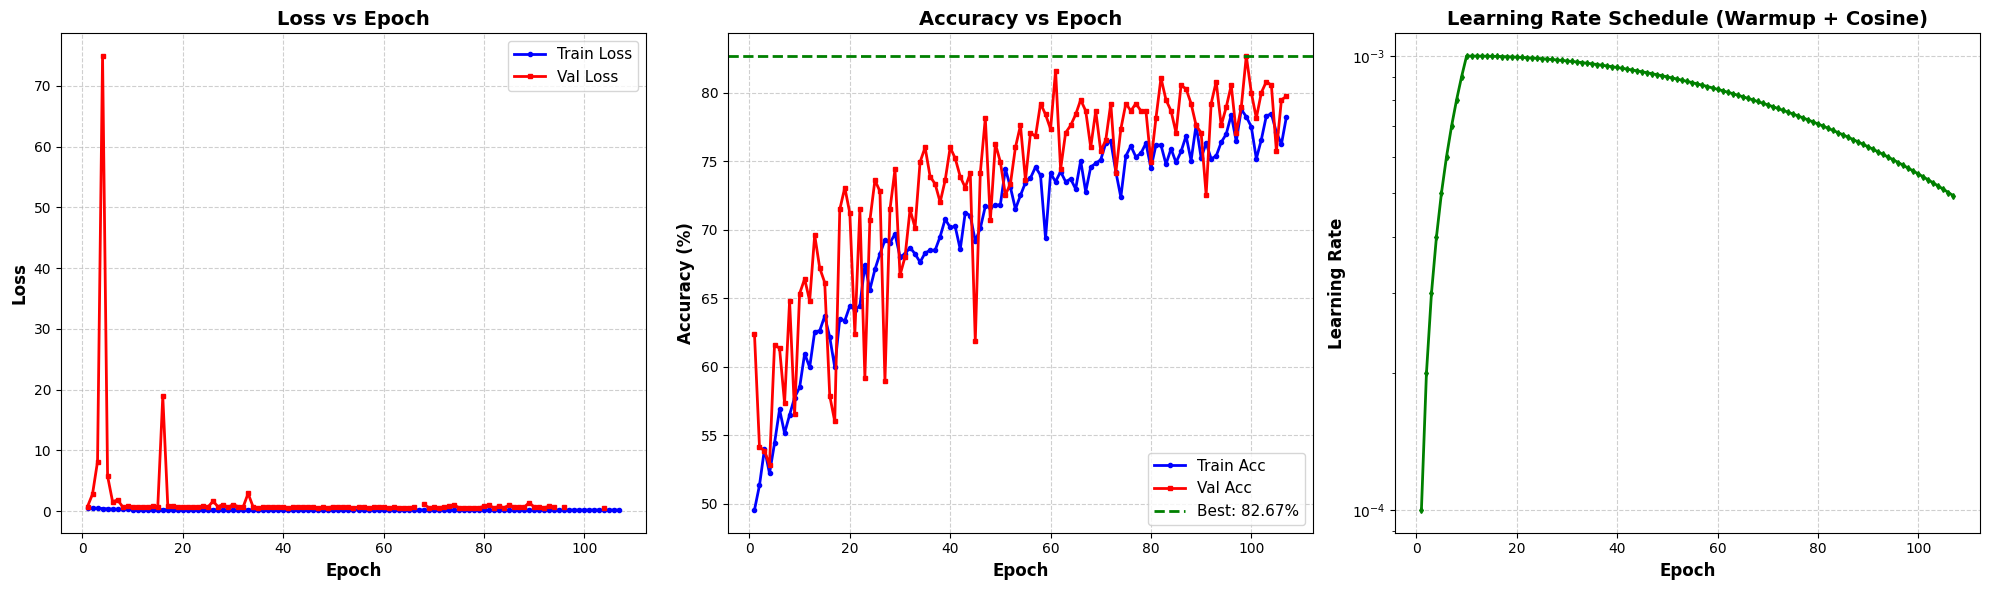


📈 Final Statistics:
   Final Train Accuracy: 0.7824 (78.24%)
   Final Val Accuracy: 0.7973 (79.73%)
   Overfitting Gap: -0.0150
   Best Epoch: 99


In [8]:
# ==================== ADVANCED RESNET TRAINING SCRIPT ====================
# Ultra-high accuracy glaucoma detection with all modern techniques

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F



# ==================== ADVANCED LOSS FUNCTIONS ====================

class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing for better generalization"""
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
    
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(-1) - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

class CombinedLoss(nn.Module):
    """Combined loss with auxiliary classifier"""
    def __init__(self, use_focal=True, focal_alpha=0.25, focal_gamma=2.0, 
                 label_smoothing=0.1, aux_weight=0.3):
        super(CombinedLoss, self).__init__()
        self.aux_weight = aux_weight
        
        if use_focal:
            self.main_criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        else:
            self.main_criterion = LabelSmoothingCrossEntropy(smoothing=label_smoothing)
        
        self.aux_criterion = nn.CrossEntropyLoss()
    
    def forward(self, outputs, labels):
        if isinstance(outputs, tuple):
            main_output, aux_output = outputs
            main_loss = self.main_criterion(main_output, labels)
            aux_loss = self.aux_criterion(aux_output, labels)
            return main_loss + self.aux_weight * aux_loss
        else:
            return self.main_criterion(outputs, labels)

# ==================== UTILITY CLASSES ====================

class EarlyStopping:
    """Early stopping with model checkpointing"""
    def __init__(self, patience=20, min_delta=0.0001, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_value = None
        self.early_stop = False
    
    def __call__(self, metric):
        if self.best_value is None:
            self.best_value = metric
            return False
        
        if self.mode == 'min':
            improved = metric < (self.best_value - self.min_delta)
        else:
            improved = metric > (self.best_value + self.min_delta)
        
        if improved:
            self.best_value = metric
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        
        return self.early_stop

class WarmupCosineScheduler:
    """Learning rate scheduler with warmup and cosine annealing"""
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lr = optimizer.param_groups[0]['lr']
        self.current_epoch = 0
    
    def step(self):
        if self.current_epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * (self.current_epoch + 1) / self.warmup_epochs
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + (self.base_lr - self.min_lr) * 0.5 * (1 + np.cos(np.pi * progress))
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        self.current_epoch += 1
        return lr

# ==================== CONFIGURATION ====================

# Model settings
NUM_CLASSES = 2
IN_CHANNELS = 3
USE_CBAM = True
USE_SPP = True
DROPOUT_RATE = 0.5

# Training settings
NUM_EPOCHS = 200
INITIAL_LR = 0.001
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32

# Advanced settings
USE_FOCAL_LOSS = True
FOCAL_ALPHA = 0.25
FOCAL_GAMMA = 2.0
LABEL_SMOOTHING = 0.1
AUX_WEIGHT = 0.3
GRADIENT_CLIP = 1.0
WARMUP_EPOCHS = 10

# Early stopping
EARLY_STOPPING_PATIENCE = 25

print("="*70)
print("🚀 Advanced ResNet-50 Training for Glaucoma Detection")
print("="*70)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Initialize model
model = AdvancedResNet50(
    num_classes=NUM_CLASSES,
    in_channels=IN_CHANNELS,
    use_cbam=USE_CBAM,
    use_spp=USE_SPP,
    dropout_rate=DROPOUT_RATE
).to(device)

print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)

print("="*70)

# ==================== TRAINING SETUP ====================

# Loss function
criterion = CombinedLoss(
    use_focal=USE_FOCAL_LOSS,
    focal_alpha=FOCAL_ALPHA,
    focal_gamma=FOCAL_GAMMA,
    label_smoothing=LABEL_SMOOTHING,
    aux_weight=AUX_WEIGHT
)

# Optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=INITIAL_LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Learning rate scheduler
scheduler = WarmupCosineScheduler(
    optimizer,
    warmup_epochs=WARMUP_EPOCHS,
    total_epochs=NUM_EPOCHS,
    min_lr=1e-6
)

# Mixed precision training
scaler = torch.amp.GradScaler('cuda')

# Early stopping
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, min_delta=0.0001, mode='min')

# Tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
learning_rates = []
best_val_acc = 0.0
best_val_loss = float('inf')

print("⚙️  Advanced Training Configuration:")
print(f"   • Model: ResNet-50 with CBAM + SPP")
print(f"   • Epochs: {NUM_EPOCHS}")
print(f"   • Initial LR: {INITIAL_LR}")
print(f"   • Warmup Epochs: {WARMUP_EPOCHS}")
print(f"   • Batch Size: {BATCH_SIZE}")
print(f"   • Loss: {'Focal Loss' if USE_FOCAL_LOSS else 'Label Smoothing'}")
print(f"   • Auxiliary Loss Weight: {AUX_WEIGHT}")
print(f"   • Dropout: {DROPOUT_RATE}")
print(f"   • Weight Decay: {WEIGHT_DECAY}")
print(f"   • Gradient Clipping: {GRADIENT_CLIP}")
print(f"   • Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print("="*70)

# ==================== TRAINING LOOP ====================

for epoch in range(NUM_EPOCHS):
    # Update learning rate
    current_lr = scheduler.step()
    learning_rates.append(current_lr)
    
    # ============ TRAINING PHASE ============
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)
    
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)
        
        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            outputs = model(images, return_aux=True)  # Get auxiliary output
            loss = criterion(outputs, labels)
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=GRADIENT_CLIP)
        
        scaler.step(optimizer)
        scaler.update()
        
        # Track metrics
        running_loss += loss.item() * images.size(0)
        
        # Get predictions from main output
        if isinstance(outputs, tuple):
            main_output = outputs[0]
        else:
            main_output = outputs
        
        _, predicted = torch.max(main_output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%',
            'lr': f'{current_lr:.6f}'
        })
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # ============ VALIDATION PHASE ============
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Store predictions for analysis
    all_preds = []
    all_labels = []
    all_probs = []
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]", leave=False)
    
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images, return_aux=False)
                loss = nn.functional.cross_entropy(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            # Store for metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.*val_correct/val_total:.2f}%'
            })
    
    val_loss /= val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Calculate additional metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Sensitivity (Recall for Glaucoma)
    glaucoma_mask = all_labels == 1
    if glaucoma_mask.sum() > 0:
        glaucoma_sensitivity = (all_preds[glaucoma_mask] == 1).sum() / glaucoma_mask.sum()
    else:
        glaucoma_sensitivity = 0.0
    
    # ============ MODEL CHECKPOINTING ============
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'glaucoma_sensitivity': glaucoma_sensitivity,
        }, "best_resnet_glaucoma.pth")
        improvement = "✅ NEW BEST!"
    else:
        improvement = ""
    
    # ============ PRINT EPOCH SUMMARY ============
    print(f"Epoch [{epoch+1:3d}/{NUM_EPOCHS}] "
          f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f} | "
          f"Glaucoma Sens: {glaucoma_sensitivity:.4f} | "
          f"LR={current_lr:.6f} {improvement}")
    
    # ============ EARLY STOPPING CHECK ============
    if early_stopping(val_loss):
        print(f"\n⚠️  Early stopping triggered at epoch {epoch+1}")
        print(f"   Best Val Acc: {best_val_acc:.4f} | Best Val Loss: {best_val_loss:.4f}")
        break

# ==================== SAVE FINAL MODEL ====================

torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}, "final_resnet_glaucoma.pth")

print("\n" + "="*70)
print("🎉 Training Complete!")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best Validation Loss: {best_val_loss:.4f}")
print(f"   Total Epochs: {len(train_losses)}")
print("="*70)

# ==================== VISUALIZATION ====================

fig = plt.figure(figsize=(20, 6))

# Loss curves
ax1 = plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Train Loss', linewidth=2, marker='o', markersize=3)
ax1.plot(epochs_range, val_losses, 'r-', label='Val Loss', linewidth=2, marker='s', markersize=3)
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Loss vs Epoch', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, linestyle='--', alpha=0.6)

# Accuracy curves
ax2 = plt.subplot(1, 3, 2)
ax2.plot(epochs_range, [acc*100 for acc in train_accuracies], 'b-', label='Train Acc', linewidth=2, marker='o', markersize=3)
ax2.plot(epochs_range, [acc*100 for acc in val_accuracies], 'r-', label='Val Acc', linewidth=2, marker='s', markersize=3)
ax2.axhline(y=best_val_acc*100, color='g', linestyle='--', linewidth=2, label=f'Best: {best_val_acc*100:.2f}%')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy vs Epoch', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, linestyle='--', alpha=0.6)

# Learning rate schedule
ax3 = plt.subplot(1, 3, 3)
ax3.plot(epochs_range, learning_rates, 'g-', linewidth=2, marker='d', markersize=3)
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax3.set_title('Learning Rate Schedule (Warmup + Cosine)', fontsize=14, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('resnet_training_metrics.png', dpi=300, bbox_inches='tight')
print("📊 Training metrics saved as 'resnet_training_metrics.png'")
plt.show()

print("\n📈 Final Statistics:")
print(f"   Final Train Accuracy: {train_accuracies[-1]:.4f} ({train_accuracies[-1]*100:.2f}%)")
print(f"   Final Val Accuracy: {val_accuracies[-1]:.4f} ({val_accuracies[-1]*100:.2f}%)")
print(f"   Overfitting Gap: {(train_accuracies[-1] - val_accuracies[-1]):.4f}")
print(f"   Best Epoch: {val_accuracies.index(max(val_accuracies)) + 1}")
print("="*70)

# Load & Test Model

🔍 Advanced ResNet-50 Model Evaluation
📱 Device: cuda
📂 Loading model from: best_resnet_glaucoma.pth
 Epoch: 99
 Val Accuracy: nan
 Val Loss: nan
 Glaucoma Sensitivity: 0.5845
✅ Model loaded successfully!

🧪 Running comprehensive evaluation...


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]



✅ Overall Accuracy: 79.47%

📊 Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Healthy     0.7727    0.9485    0.8516       233
    Glaucoma     0.8652    0.5423    0.6667       142

    accuracy                         0.7947       375
   macro avg     0.8189    0.7454    0.7592       375
weighted avg     0.8077    0.7947    0.7816       375


💾 Confusion matrix saved as 'resnet_confusion_matrix.png'


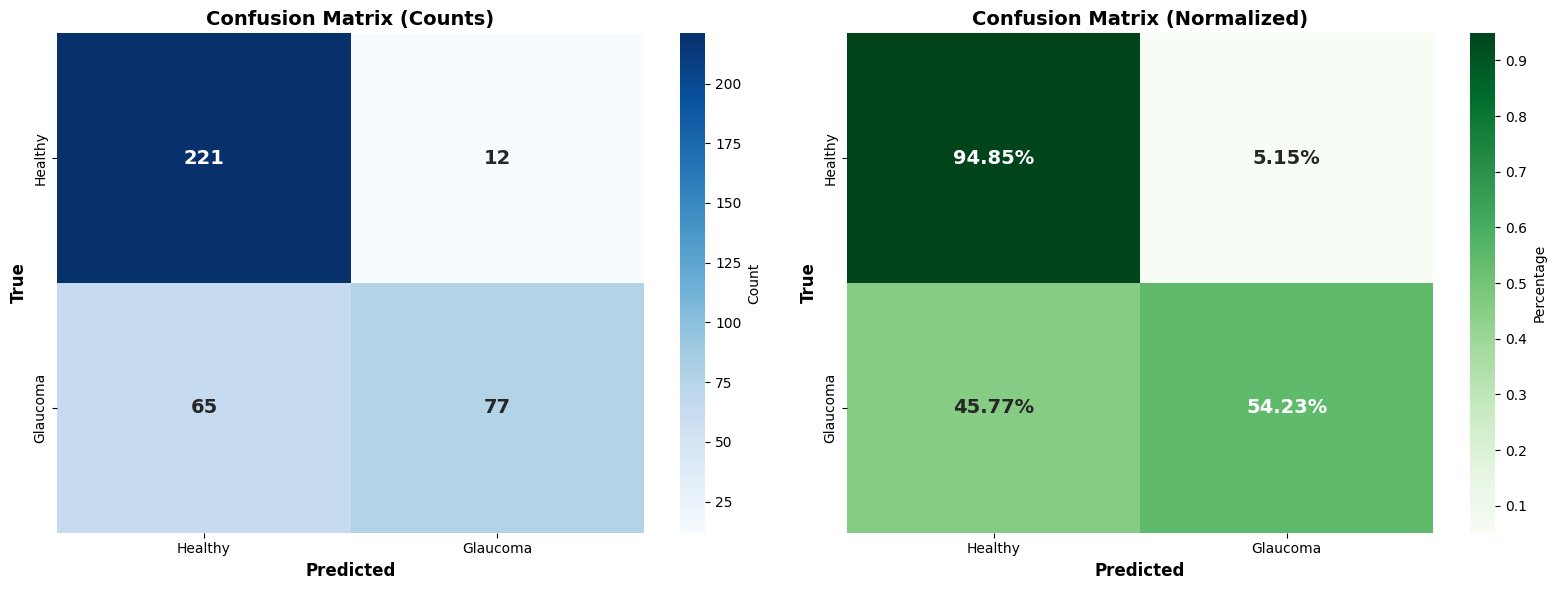


📈 Per-Class Performance:
----------------------------------------------------------------------
 Healthy     : Accuracy =  94.85% | Count =  233
 Glaucoma    : Accuracy =  54.23% | Count =  142
💾 ROC and PR curves saved as 'resnet_roc_pr_curves.png'


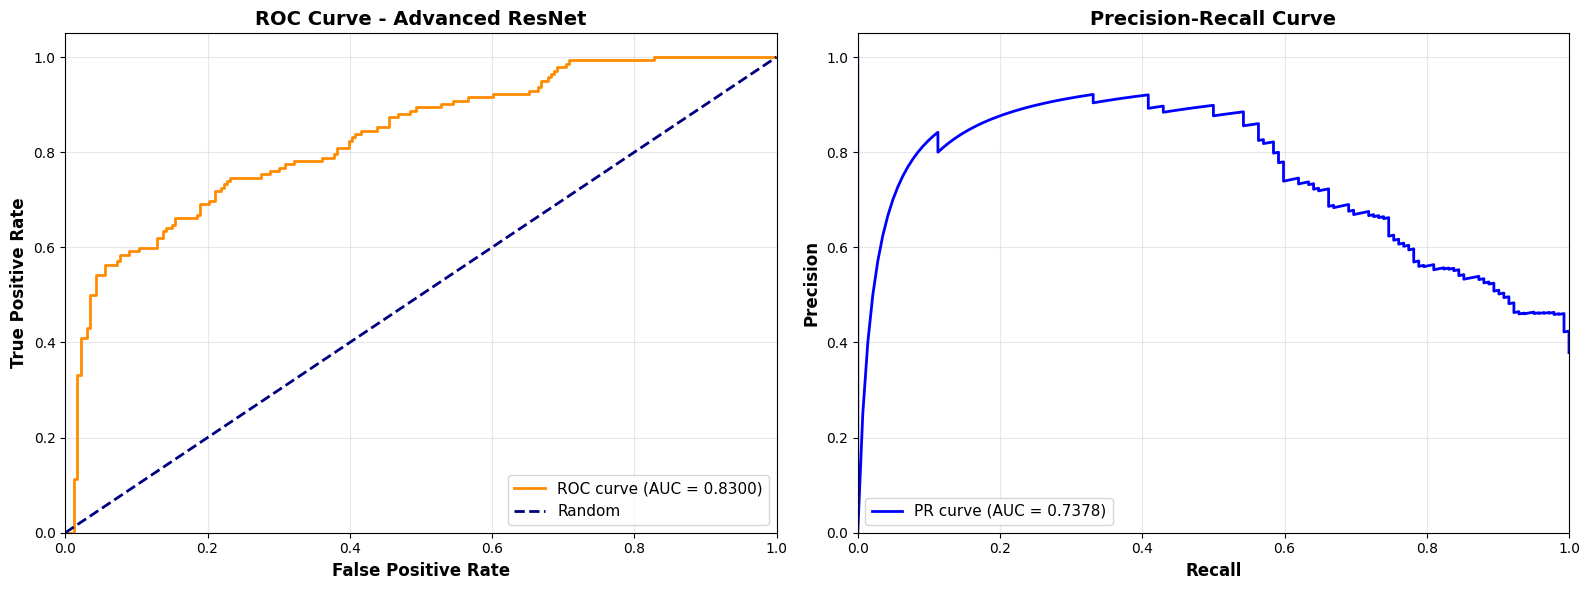


🎯 Optimal Classification Threshold:
 Threshold: 0.4184
 True Positive Rate (Sensitivity): 0.7465
 False Positive Rate: 0.2318
 Specificity: 0.7682

📊 Medical Performance Metrics:
 Sensitivity (Recall): 0.5423 (54.23%)
 Specificity: 0.9485 (94.85%)
 Precision (PPV): 0.8652 (86.52%)
 Negative Predictive Value (NPV): 0.7727 (77.27%)
 F1-Score: 0.6667
 ROC-AUC: 0.8300
 PR-AUC: 0.7378

✅ Evaluation Complete!

📋 ADVANCED RESNET-50 PERFORMANCE SUMMARY

🎯 Overall Performance:
 Accuracy: 79.47%
 ROC-AUC: 0.8300
 PR-AUC: 0.7378

🔬 Glaucoma Detection (Most Important):
 Sensitivity (True Positive Rate): 54.23%
 Correctly detected: 77 out of 142 glaucoma cases
 Missed cases (False Negatives): 65

✅ Healthy Detection:
 Specificity (True Negative Rate): 94.85%
 Correctly detected: 221 out of 233 healthy cases
 False Alarms (False Positives): 12

⚕️ Clinical Interpretation:
 ❌ Low glaucoma detection. Model needs improvement.
 ✅ Good healthy detection. Acceptable specificity.



In [9]:
# ==================== ADVANCED RESNET EVALUATION SCRIPT ====================
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
from tqdm import tqdm

# Import AdvancedResNet50 model (must be defined or imported)
# from resnet_model import AdvancedResNet50  # Adjust as needed

# ==================== 🔧 EDIT HERE: YOUR DATA LOADER ====================
# TODO: Make sure val_loader is defined (e.g., from your DataLoader setup)
# ==================== END EDIT SECTION ====================

print("="*70)
print("🔍 Advanced ResNet-50 Model Evaluation")
print("="*70)

# Define class names
classes = ['Healthy', 'Glaucoma']

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Device: {device}")

# ==================== LOAD MODEL ====================
# Initialize model
model = AdvancedResNet50(
    num_classes=2,
    in_channels=3,
    use_cbam=True,
    use_spp=True,
    dropout_rate=0.5
).to(device)

# Load checkpoint
checkpoint_path = "best_resnet_glaucoma.pth"
print(f"📂 Loading model from: {checkpoint_path}")
model_loaded = False

try:
    # FIXED: Set weights_only=False for PyTorch 2.6+ compatibility (trusted checkpoint)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        print(f" Epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f" Val Accuracy: {checkpoint.get('val_loss', 'N/A'):.4f}")
        print(f" Val Loss: {checkpoint.get('val_loss', 'N/A'):.4f}")
        if 'glaucoma_sensitivity' in checkpoint:
            print(f" Glaucoma Sensitivity: {checkpoint['glaucoma_sensitivity']:.4f}")
    else:
        state_dict = checkpoint
    
    # Remove 'module.' prefix if model was trained with DataParallel
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict, strict=False)
    model.eval()
    print("✅ Model loaded successfully!")
    model_loaded = True

except FileNotFoundError:
    print(f"❌ Error: Model file '{checkpoint_path}' not found!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("⚠️  Evaluation will skip or use random weights—results invalid!")
    # Don't exit; let user decide, but flag model_loaded=False

print("="*70)

if not model_loaded:
    print("\n❌ Skipping evaluation due to model load failure.")
    print("="*70)
    exit()  # Or remove this to proceed with warning

# ==================== EVALUATION ====================
all_preds = []
all_labels = []
all_probs = []
print("\n🧪 Running comprehensive evaluation...")
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        
        # Get predictions
        outputs = model(images, return_aux=False)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        
        # Calculate accuracy
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# ==================== METRICS ====================
overall_accuracy = correct / total
print(f"\n✅ Overall Accuracy: {overall_accuracy * 100:.2f}%")
print("="*70)

# Classification Report
print("\n📊 Detailed Classification Report:")
print("-"*70)
report = classification_report(all_labels, all_preds, target_names=classes, digits=4)
print(report)

# ==================== CONFUSION MATRIX ====================
cm = confusion_matrix(all_labels, all_preds)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix (Count)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=axes[0],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_xlabel("Predicted", fontsize=12, fontweight='bold')
axes[0].set_ylabel("True", fontsize=12, fontweight='bold')
axes[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight='bold')

# Confusion Matrix (Normalized)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens",
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=axes[1],
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_xlabel("Predicted", fontsize=12, fontweight='bold')
axes[1].set_ylabel("True", fontsize=12, fontweight='bold')
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('resnet_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("\n💾 Confusion matrix saved as 'resnet_confusion_matrix.png'")
plt.show()

# ==================== PER-CLASS METRICS ====================
print("\n📈 Per-Class Performance:")
print("-"*70)
cm_diag = np.diag(cm)
class_counts = cm.sum(axis=1)
for i, cls in enumerate(classes):
    class_acc = cm_diag[i] / class_counts[i] * 100
    print(f" {cls:12s}: Accuracy = {class_acc:6.2f}% | Count = {class_counts[i]:4d}")

# ==================== ROC AND PR CURVES ====================
# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve - Advanced ResNet', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, color='blue', lw=2,
             label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet_roc_pr_curves.png', dpi=300, bbox_inches='tight')
print("💾 ROC and PR curves saved as 'resnet_roc_pr_curves.png'")
plt.show()

# ==================== OPTIMAL THRESHOLD ====================
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_tpr = tpr[optimal_idx]
optimal_fpr = fpr[optimal_idx]

print("\n🎯 Optimal Classification Threshold:")
print(f" Threshold: {optimal_threshold:.4f}")
print(f" True Positive Rate (Sensitivity): {optimal_tpr:.4f}")
print(f" False Positive Rate: {optimal_fpr:.4f}")
print(f" Specificity: {1-optimal_fpr:.4f}")

# ==================== MEDICAL METRICS ====================
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

print("\n📊 Medical Performance Metrics:")
print(f" Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f" Specificity: {specificity:.4f} ({specificity*100:.2f}%)")
print(f" Precision (PPV): {precision_val:.4f} ({precision_val*100:.2f}%)")
print(f" Negative Predictive Value (NPV): {npv:.4f} ({npv*100:.2f}%)")
print(f" F1-Score: {f1_score:.4f}")
print(f" ROC-AUC: {roc_auc:.4f}")
print(f" PR-AUC: {pr_auc:.4f}")

print("\n" + "="*70)
print("✅ Evaluation Complete!")
print("="*70)

# ==================== PERFORMANCE SUMMARY ====================
print("\n" + "="*70)
print("📋 ADVANCED RESNET-50 PERFORMANCE SUMMARY")
print("="*70)
print(f"\n🎯 Overall Performance:")
print(f" Accuracy: {overall_accuracy*100:.2f}%")
print(f" ROC-AUC: {roc_auc:.4f}")
print(f" PR-AUC: {pr_auc:.4f}")

print(f"\n🔬 Glaucoma Detection (Most Important):")
print(f" Sensitivity (True Positive Rate): {sensitivity*100:.2f}%")
print(f" Correctly detected: {tp} out of {tp+fn} glaucoma cases")
print(f" Missed cases (False Negatives): {fn}")

print(f"\n✅ Healthy Detection:")
print(f" Specificity (True Negative Rate): {specificity*100:.2f}%")
print(f" Correctly detected: {tn} out of {tn+fp} healthy cases")
print(f" False Alarms (False Positives): {fp}")

print(f"\n⚕️ Clinical Interpretation:")
if sensitivity >= 0.95:
    print(f" ⭐ Excellent glaucoma detection! Very few missed cases.")
elif sensitivity >= 0.90:
    print(f" ✅ Good glaucoma detection. Acceptable for screening.")
elif sensitivity >= 0.85:
    print(f" ⚠️ Moderate glaucoma detection. Consider improving sensitivity.")
else:
    print(f" ❌ Low glaucoma detection. Model needs improvement.")

if specificity >= 0.95:
    print(f" ⭐ Excellent healthy detection! Very few false alarms.")
elif specificity >= 0.90:
    print(f" ✅ Good healthy detection. Acceptable specificity.")
else:
    print(f" ⚠️ Consider improving specificity to reduce false alarms.")

print("\n" + "="*70)